#### GA Analysis

This code varies the masked section of pLac to see how it relates to the upper and lower bounds of the promoter's expression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import time
import itertools

from GA_params_test import GeneticAlgorithm

from GA_param_function_module import *

In [2]:
cnn_model_path = '../../Models/CNN_6_1_2.keras'
target_expressions = [0, 1]
precision = 0.001
lineages = 2
seed = 0

# Assuming 20bp up element, 6bp -35, 18bp spacer, 6bp -10, 24bp discriminator, and 17bp ITR
pLac_full = 'AATACTAGAGGTCTTCCGACTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGGCGGGAAGACAACTAGGGG'
pLac = {
    'UP' : 'AATACTAGAGGTCTTCCGAC',
    'h35' : 'TTTACA',
    'spacs' : 'CTTTATGCTTCCGGCTCG',
    'h10' : 'TATGTT',
    'disc' : 'GTGTGGGC',
    'ITR' : 'GGGAAGACAACTAGGGG',
}

In [3]:
ga = GeneticAlgorithm(
    cnn_model_path=cnn_model_path,
    masked_sequence=pLac_full,
    generations=1,
    pop_size=1,
    base_mutation_rate=0,
    target_expression=0,
    precision=precision,
    verbose=0,
    seed=0,
)
_pLac, pLac_expr = ga.run()
pLac_expr = pLac_expr[0]
print(pLac_expr)

Instructions for updating:
Use tf.identity with explicit device placement instead.
0.33783603


c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Testing expression ranges for combinations of -35, spacer, -10

In [4]:
# Generate all combinations of pLac subelements combinations
elements = ['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']
element_subset = ['h35', 'spacs', 'h10']

mask_combinations = []
for r in range(len(pLac.keys()) + 1):
    mask_combinations.extend(itertools.combinations(element_subset, r))

mask_combinations = mask_combinations[1:]

In [5]:
subset_results = []

# Initialize tqdm progress bar
total_iterations = len(mask_combinations) * len(target_expressions) * lineages
progress_bar = tqdm(total=total_iterations, desc="Processing Combinations")

start_time = time.time()

for combination in mask_combinations:
    # Generate the masked sequence
    masked_sequence = pLac_full
    for element in combination:
        masked_sequence = masked_sequence.replace(pLac[element], 'N' * len(pLac[element]))

    # Run the GA with the masked sequence for high and low expression
    for target_expression in target_expressions:
        ga = GeneticAlgorithm(
            cnn_model_path=cnn_model_path,
            masked_sequence=masked_sequence,
            target_expression=target_expression,
            precision=precision,
            verbose=0,
            seed=seed,
        )
        best_sequences, best_predictions = ga.run(lineages)
        
        for best_sequence, best_prediction in zip(best_sequences, best_predictions):
            # Save the subset_results in a dictionary
            subset_results.append({
                'combination': '_'.join(combination),
                'target_expression': target_expression,
                'best_sequence': best_sequence,
                'best_prediction': best_prediction,
            })

            # Update progress bar
            progress_bar.update(1)
            elapsed_time = time.time() - start_time
            progress_bar.set_postfix({
                "Elapsed": f"{elapsed_time:.2f}s",
                "ETA": f"{(elapsed_time / progress_bar.n) * (total_iterations - progress_bar.n):.2f}s"
            })
                

# Close progress bar
progress_bar.close()

# Save the subset_results in a dataframe
subset_results_df = pd.DataFrame(subset_results)


Processing Combinations:  36%|███▌      | 10/28 [00:19<00:37,  2.11s/it, Elapsed=19.91s, ETA=35.83s]

KeyboardInterrupt: 

In [ ]:
subset_results_df.to_csv('continuous_results.csv', index=False)

,combination,target_expression,best_sequence,best_prediction
0,h35,0,TCCCCG,0.235244
1,h35,0,TCTCTC,0.241055
2,h35,1,TTGACT,0.392301
3,h35,1,TTGACC,0.376058
4,spacs,0,TGTATTGGCCCCCAAGGC,0.188456
5,spacs,0,GTTATTGCCCCCCCCCCT,0.194749
6,spacs,1,ACCGGTAATATATAATAT,0.695156
7,spacs,1,AGGCTATAATGATATAAT,0.783992
8,h10,0,AGTTGC,0.281347
9,h10,0,GCTCTT,0.281615


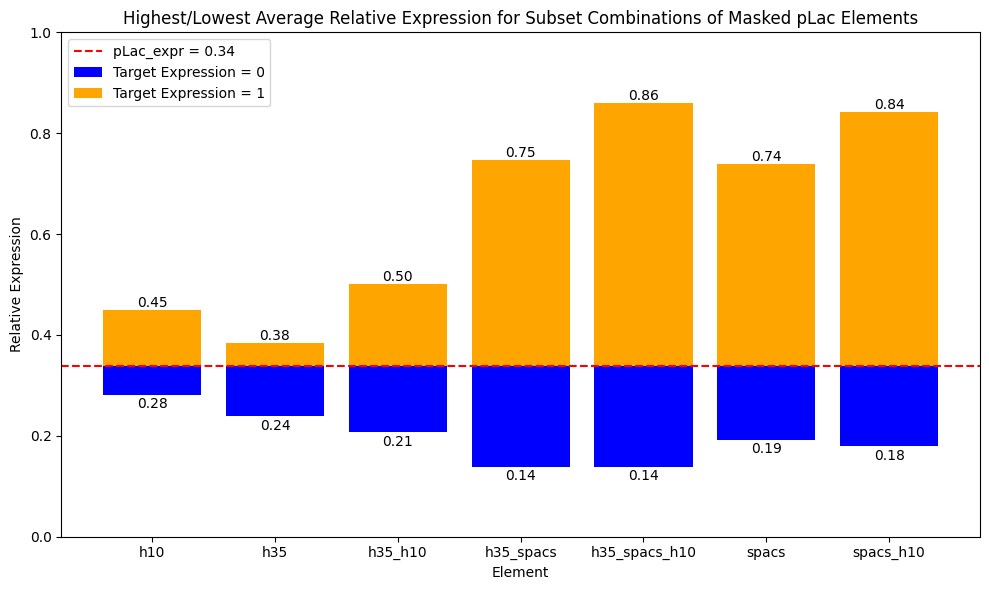

In [ ]:
average_subset_results = subset_results_df.groupby(['combination', 'target_expression'])['best_prediction'].mean().reset_index()
average_subset_results['combination'] = pd.Categorical(average_subset_results['combination'], ordered=True)
average_subset_results = average_subset_results.sort_values('combination')

plt.figure(figsize=(10, 6))

data_target_0 = average_subset_results[average_subset_results['target_expression'] == 0]
data_target_1 = average_subset_results[average_subset_results['target_expression'] == 1]

bars_0 = plt.bar(data_target_0['combination'], data_target_0['best_prediction'] - pLac_expr,
                 bottom=pLac_expr, label='Target Expression = 0', color='blue')
bars_1 = plt.bar(data_target_1['combination'], data_target_1['best_prediction'] - pLac_expr,
                 bottom=pLac_expr, label='Target Expression = 1', color='orange')

for bar, label in zip(bars_0, data_target_0['best_prediction']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y() - 0.005,
             f'{label:.2f}', ha='center', va='top', fontsize=10)

for bar, label in zip(bars_1, data_target_1['best_prediction']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(),
             f'{label:.2f}', ha='center', va='bottom', fontsize=10)

plt.axhline(y=pLac_expr, color='red', linestyle='--', label=f'pLac = {pLac_expr:.2f}')

plt.xlabel('Element')
plt.ylabel('Relative Expression')
plt.ylim(0, 1)
plt.title('Highest/Lowest Average Relative Expression for Subset Combinations of Masked pLac Elements')
plt.legend()
plt.tight_layout()
plt.grid(False)

plt.show()
